# Reference
https://pyimagesearch.com/2016/03/21/ordering-coordinates-clockwise-with-python-and-opencv/

In [146]:
import numpy as np
import cv2
import imutils

from scipy.spatial import distance
from imutils import contours, perspective
from matplotlib import pyplot as pltx

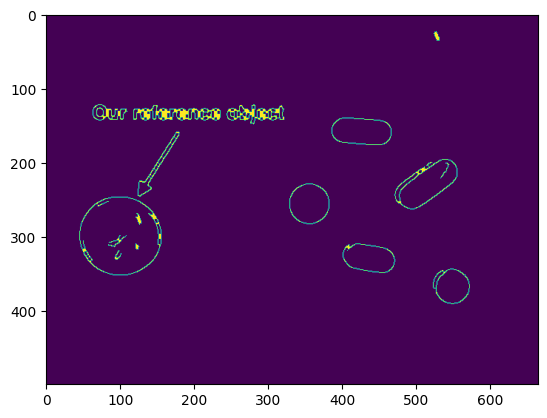

In [147]:
def order_point_old(points: np.ndarray):
    rect = np.zeros((4,2), dtype='float32')
    
    # get top left, bottom right
    s = points.sum(axis=1)
    rect[0] = points[np.argmin(s)]
    rect[2] = points[np.argmax(s)]
    
    # get top right, bottom left
    diff = np.diff(points, axis=1)
    rect[1] = points[np.argmin(diff)]
    rect[3] = points[np.argmax(diff)]
    
    return rect

# np.newaxis: https://stackoverflow.com/questions/29241056/how-do-i-use-np-newaxis
def order_point(points: np.ndarray):
    x_sorted = points[np.argsort(points[:,0]),:]
    
    left_most = x_sorted[:2,:]
    left_most = left_most[np.argsort(left_most[:,1]),:]
    tl, bl = left_most
    
    right_most = x_sorted[2:,:]
    # increase tl dimension to 2d array for calculate each distance pairs
    dist = distance.cdist(tl[np.newaxis], right_most, 'euclidean')[0]
    # ::-1 means splice step 1 and in reverse order
    br, tr = right_most[np.argsort(dist)[::-1], :]
    
    return np.array([tl, tr, br, bl], dtype='float32')
    
    
    
image = cv2.imread('../resources/object-measure/sample.jpg')
image = imutils.resize(image, height=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7,7), 0)

edged = cv2.Canny(gray, 50, 100)
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)

plt.imshow(edged)

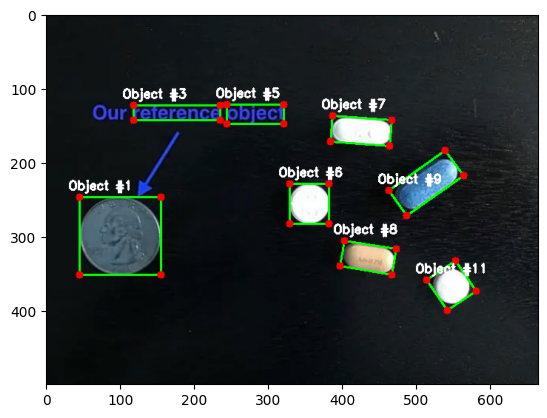

In [148]:
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts, _ = contours.sort_contours(cnts)

for i, c in enumerate(cnts):
    if cv2.contourArea(c) < 1000:
        continue
    
    box = cv2.minAreaRect(c)
    box = cv2.boxPoints(box)
    box = np.array(box, dtype='int')
    cv2.drawContours(image, [box], -1, (0,255,0), 2)
    
    rect = order_point(box)
    
    for x,y in rect:
        cv2.circle(image, (int(x), int(y)), 5, (255,0,0), -1)
        
    cv2.putText(image, "Object #{}".format(i + 1),
        (int(rect[0][0] - 15), int(rect[0][1] - 10)),
        cv2.FONT_HERSHEY_SIMPLEX, 0.55, (255, 255, 255), 2)

plt.imshow(image)